In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import pims

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#%matplotlib inline
%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
seg_len = 15

In [3]:
def classify1(features, MX=5):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        print(BIC[i])
        if BIC[i] < lowest_bic:
            lowest_bic = BIC[i]
            best_gmm = gmm

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type='full', random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [4]:
df = pd.read_csv("data.csv")
df.drop(df.columns[0], inplace=True, axis=1)
scaler = MinMaxScaler()
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])
display(df.describe())
display(df.head(5))

,time,frame,x,y,w,h,Rf,mx,my
count,19543.000000,19543.000000,19543.000000,19543.000000,19543.000000,19543.00000,19543.000000,19543.000000,19543.000000
mean,206.995370,5174.884255,139.911963,108.873791,32.826025,44.47439,0.571592,-0.322309,-0.316361
std,95.588185,2389.704621,93.254491,60.504380,19.086963,30.06377,0.201121,2.749506,3.459482
min,10.600000,265.000000,7.500000,9.000000,15.000000,15.00000,0.029567,-20.224224,-20.096633
25%,126.200000,3155.000000,75.500000,49.500000,20.000000,23.00000,0.471920,-1.472077,-1.693914
50%,223.080000,5577.000000,117.500000,111.500000,26.000000,34.00000,0.610126,-0.641855,-0.874777
75%,285.320000,7133.000000,170.500000,156.500000,39.000000,54.00000,0.719611,0.437051,0.396538
max,356.680000,8917.000000,418.500000,232.500000,143.000000,144.00000,0.973211,20.172071,26.380231


,time,frame,x,y,w,h,Rf,mx,my
0,10.60,265,20.0,59.5,22,35,0.085098,-1.309833,-1.772727
1,10.60,265,85.5,63.5,27,25,0.088610,-0.965447,0.571138
2,10.76,269,20.0,65.0,22,46,0.104038,-1.195136,-5.979589
3,10.76,269,85.0,64.0,26,26,0.130578,-0.928873,0.094629
4,10.92,273,20.0,65.0,22,46,0.143719,-1.138239,-5.338115


-146452.126843
-202978.288847
-218291.574549
-223552.239108
-232342.848654
5


<IPython.core.display.Javascript object>


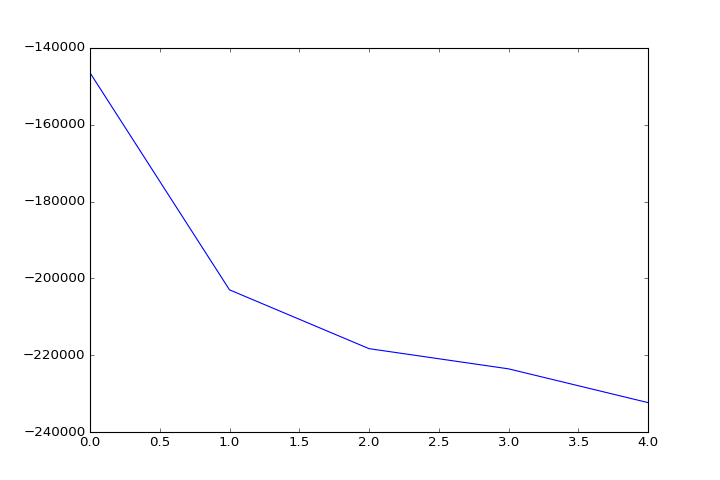

In [5]:
bgmm = classify1(df2)

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3 = df3.groupby('time').agg('max')
df3.reset_index(inplace=True)

display(df3.head(10))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

for i in range(len(df3)):
    r = df3.iloc[i]
    pn.append(r.drop("time").ravel())
    if r.time - last_t > seg_len:
        last_t = r.time
        PN.append(pn)
        pn = []

print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,0,1,2,3,4
0,10.60,0.986717,1.003014e-13,0.000126,0.017577,1.019818e-15
1,10.76,0.989278,2.393210e-12,0.009476,0.989642,6.671057e-15
2,10.92,0.988810,6.597071e-11,0.024066,0.967878,1.234375e-14
3,11.08,0.984397,3.022795e-09,0.053803,0.921178,3.385568e-14
4,11.24,0.029273,5.261891e-11,0.115208,0.938411,5.258920e-24
5,11.40,0.032389,1.407047e-09,0.218421,0.844309,9.031175e-24
6,11.56,0.035182,2.853615e-08,0.358447,0.740577,1.499214e-23
7,11.72,0.983542,2.755931e-03,0.744034,0.255966,3.494291e-18
8,11.88,0.028792,2.719365e-06,0.883497,0.340906,1.315988e-23
9,12.04,0.770315,2.230665e-01,0.914271,0.085708,1.126411e-17


N = 23
N[ 0 ]= 95
N[ 1 ]= 94
N[ 2 ]= 94
N[ 3 ]= 94
N[ 4 ]= 94
N[ 5 ]= 94
N[ 6 ]= 94
N[ 7 ]= 94
N[ 8 ]= 94
N[ 9 ]= 94
N[ 10 ]= 94
N[ 11 ]= 94
N[ 12 ]= 94
N[ 13 ]= 94
N[ 14 ]= 94
N[ 15 ]= 94
N[ 16 ]= 94
N[ 17 ]= 94
N[ 18 ]= 94
N[ 19 ]= 94
N[ 20 ]= 94
N[ 21 ]= 94
N[ 22 ]= 94


In [7]:
from hmmlearn import hmm

hmms1 = []

N = len(PN)

for i in range(N):
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(PN[i])
    hmms1.append(hmm1)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing

In [8]:
Sij = np.zeros((N,N), np.float64)

for i in range(N):
    for j in range(N):
        s1 = hmms1[i].score(PN[j]) * (1.0 / len(PN[j]))
        s2 = hmms1[j].score(PN[i]) * (1.0 / len(PN[i]))
        Sij[i, j] = 0.5 * (s1 + s2)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


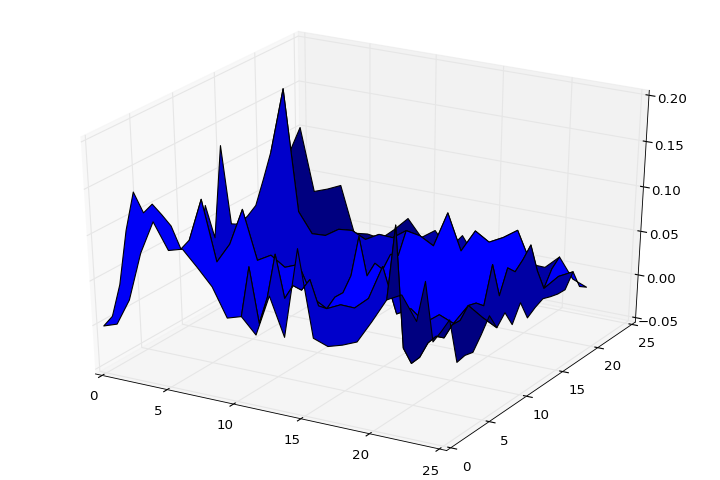

In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0
    for j in range(N):
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
plot_array(Snorm)

<IPython.core.display.Javascript object>


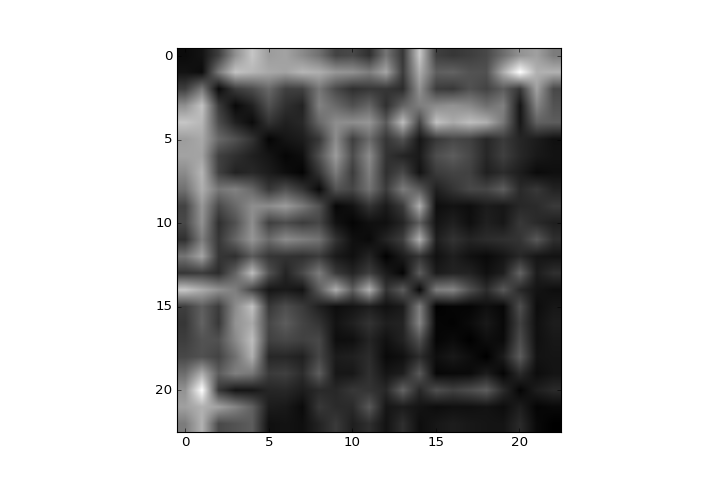

In [10]:
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

array([[-0.27834328, -0.18899291, -0.1851615 , -0.1641046 ],
       [ 0.35547517, -0.21665678, -0.25347639, -0.23918286],
       [-0.25634071,  0.08574959,  0.01335472,  0.07375396],
       [ 0.00796197, -0.17147836, -0.17660977, -0.07570641],
       [-0.11221135, -0.06052501,  0.29083888,  0.0819762 ],
       [ 0.05196966, -0.1691622 , -0.23260395, -0.16876787],
       [-0.02316539,  0.05095105,  0.20233549,  0.11548742],
       [-0.0676925 ,  0.05034056,  0.17853625,  0.32856161],
       [ 0.1190192 ,  0.18046026,  0.15617505,  0.22035044],
       [-0.02753268, -0.24597847,  0.22781813,  0.21851396],
       [-0.02171032,  0.31425958,  0.09592131, -0.13238998],
       [ 0.20361652, -0.17491104,  0.2800194 , -0.2245201 ],
       [ 0.57265357,  0.19650439,  0.10100084,  0.07039139],
       [ 0.02738345, -0.29833501, -0.1240711 ,  0.00347525],
       [ 0.41294939, -0.14752866, -0.14163772,  0.49021066],
       [ 0.10272754, -0.19764233,  0.2578573 , -0.43165101],
       [ 0.16734927, -0.

8.83983120316
18.4776246736
8.67731147714
-10.1853716114
4


<IPython.core.display.Javascript object>


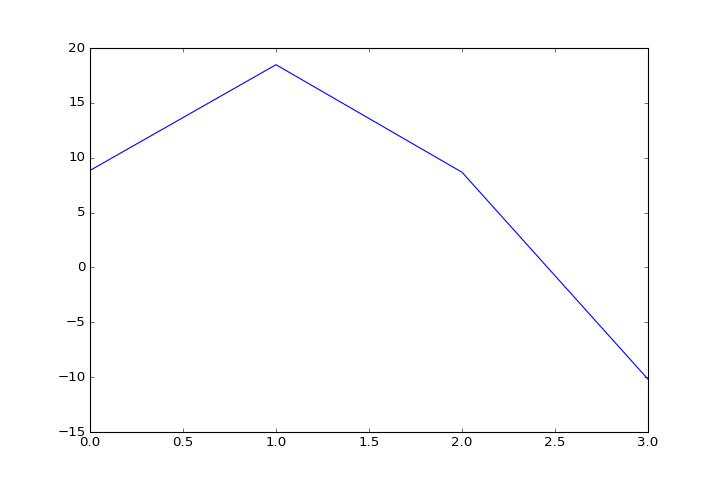

In [13]:
Km = int(N / 5)
Snorm_vals, Snorm_vecs = np.linalg.eig(Snorm)
indices = np.argsort(Snorm_vals)[::-1][:Km]
top_vecs = Snorm_vecs[indices].T
display(top_vecs)
eig_gmm = classify1(top_vecs, Km)
finalK = eig_gmm.n_components

In [41]:
final_hmms = []
final_nk = []
top_classes = eig_gmm.predict(top_vecs)
for i in range(finalK):    
    tmp1 = []
    num = 0
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]    
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(tmp1)
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.5/dist-packages/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing

In [59]:
def calc_final_prob(samples):
    res = 0
    for i in range(finalK):
        res += np.exp(final_hmms[i].score(samples)) * (float(final_nk[i]) / float(N))
    return res

TestPN = df3.drop(["time"], axis=1)
test_arr = []
scrs = []
for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)    
    scrs.append(np.log(calc_final_prob(test_arr)) / (i + 1))

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/hmmlearn/base.py:462: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


In [63]:
Qt = 0
alpha = 0.5

qts = []
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs[i] - scrs[i - 1])    
    qts.append(Qt)
display(qts)    

[-11.279123314489043,
 -2.4837779445631534,
 -0.17098158334925873,
 0.47402394987069407,
 0.52721362910451774,
 0.4902571111641042,
 0.41775382583948723,
 0.074641023604649498,
 -0.036381882033029736,
 -0.767536479608113,
 -0.92542461144247823,
 -0.31041724823064809,
 -0.34265798738556413,
 -0.3289510297776238,
 -0.092759458771738135,
 0.027037606873838188,
 -0.10764029622951891,
 -0.044497896851805184,
 -0.039978921207581022,
 0.092662243785176707,
 0.13764335933232519,
 0.16507234552058281,
 0.16455412027286248,
 0.16417284669324231,
 0.15498337998993844,
 0.14990665174378423,
 0.11956841910776254,
 0.1491368893980772,
 0.089164466425441333,
 0.097538515895901984,
 0.097033564855211904,
 0.093429585243762908,
 0.097173112456481817,
 0.094690224207278878,
 0.09149508405905292,
 0.086121104930557246,
 0.076290909166250032,
 0.070410222911150511,
 0.073184559842146668,
 0.057385077377349714,
 0.061222368877384775,
 0.056051986005260526,
 0.049815238293163651,
 0.047550507479362542,
 0.0